In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt


In [2]:
exchanges = {
    'binance':
        {
            'bitcoin':'BTC',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USDT',
        },
    'coinbase':
        {
            'bitcoin':'BTC',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            #'ripple':'xrp',
            'dollar':'USD',
        }, 
    'ftx':
        {
            'bitcoin':'BTC',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USD',
        }, 
    'bitmex':
        {
            'bitcoin':'XBT',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USD',
        },
    'kraken':
        {
            'bitcoin':'XBT',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USD',
        },
    }

## Loading Fees

This section will read the fees.csv file and create a single 3 dimensional table with the notional and requivalent fees for every exchange.

Once this table is created, one can call the function "get_fee", specifying the notional mount of the trade and the exchange to extract the corresponding fee.

In [3]:

df_fees = pd.read_csv('fees.csv')

# to convert string list into actual list
def get_string(df, row, col):
    # df: dataframe of the fees
    # row: row index
    # col: column index
    str = df.iloc[row,col]
    str = str.strip('][').split(', ')
    return str

def get_fee(notional, fees_table, exch):
    # notional: amount of the order passed
    # fees_table: 3D summary table of the fees
    # exch: the exchange

    # finding the fees table for selected exchange
    for idx in range(len(fees_table)):
        if fees_table[idx][0]==exch:
            table = fees_table[idx]
            break
    # finding relevant fee for chosen notional depending on the bracket it belongs to
    for i in range(len(table)-1):
        try:
            if notional<=table[i+1][0] or i+1==len(table)-1:
                taker=table[i+1][1]
                maker=table[i+1][2]
                break
        except:
            taker=table[i+1][1]
            maker=table[i+1][2]
            break
    return taker, maker

# creating a complete fees table for every exchange
fees_table = []
for i,col in enumerate(df_fees.columns[1:]):
    exchange=[col]
    str_taker = get_string(df_fees,0,i+1)
    str_maker = get_string(df_fees,1,i+1)
    str_notional = get_string(df_fees,2,i+1)
    for j in range(len(str_notional)):
        row = [float(str_notional[j]),float(str_taker[j]),float(str_maker[j])]
        exchange.append(row)
    fees_table.append(exchange)

## Loading the Data

This is the part where we load all of the order books from the relevant cryptocurrency and exchange. The six days will be concatenated into a single order book called "ob_fq".

The user can change the underlying asset and exchange in this section.

In [4]:
days = 6
date = datetime.datetime(2022, 2, 28)
dates = [(date + datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(days)]

In [5]:
exch = 'binance'
asset = 'ethereum'

# concatenate all date over the 6 day period into single dataframe resampled by frequency
ob_fq = pd.DataFrame()
for date_str in dates:
    # We have to deal with exceptions such as USDT instead of USD
    try:
        path = 'tardis_raw.nosync/'+exch+'/'+exch+'_book_snapshot_5_'+date_str+'_'+exchanges[exch][asset]+exchanges[exch]['dollar']+'.csv.gz'
        ob = pd.read_csv(path, compression='gzip')
    except Exception as e:
        print(e)
        path = 'tardis_raw.nosync/'+exch+'/'+exch+'_book_snapshot_5_'+date_str+'_'+exchanges[exch][asset]+'USDT'+'.csv.gz'
        ob = pd.read_csv(path, compression='gzip')
        pass
    ob.sort_values(by='timestamp')
    ob['datetime'] = pd.to_datetime(ob['timestamp'], unit='us')
    ob_fq=pd.concat([ob_fq, ob], ignore_index=True)

In [6]:
ob_fq['mid_price'] = (ob_fq['asks[0].price'] + ob_fq['bids[0].price'])/2

## Finding the traded price and traded volume between each timestamp

1) The bid and ask price hasn't moved, there are 3 possibilities:
- There has been no trades 
- Part of the asks[0] amount has beed executed at asks[0] price
- Part of the bids[0] amount has beed executed at bids[0] price

2) The price has shifted upwards:
- There has been buying market orders with total volumes that exceed asks[0].amount
- We compute the VWAP from the executed ASK orders

3) The price has shifted downwards:
- There has been selling market orders with total volumes that exceed bids[0].amount
- We compute the VWAP from the executed BID orders

REMARK: there can be simultaneous buying and selling orders between two timestamps, in that scenario we compute the VWAP of the executed bids AND asks


DEPTH ISSUE: if it was a big buy order at market price, we might not have enough market depth to compute an accurate VWAP....

ORDER FLOW ISSUE: if some (or none) orders at x have been executed but new orders came in at x (which makes the difference (t-1) - (t) < 0)


In [7]:
import progressbar

bar = progressbar.ProgressBar(maxval=ob_fq.shape[0]).start()

big_orders = 0

last_traded_price = ob_fq['mid_price'].iloc[0]
t_price = [0]
t_vol = [0]
t_vol_abs = [0]
for i in range(1,ob_fq.shape[0]):
    bar.update(i)

    # we will store the executed price * executed amount in this variable
    weighted_traded_price = 0

    # we will store the executed volume ("+"" for trades at ask price and "-" for trades at bid price)
    traded_volume = 0

    # we will store the absolute executed volume in this variable
    traded_volume_abs = 0
    
    # no change in the bid ask prices
    if ob_fq['asks[0].price'].iloc[i-1] == ob_fq['asks[0].price'].iloc[i] and ob_fq['bids[0].price'].iloc[i-1] == ob_fq['bids[0].price'].iloc[i]:
        # No trade
        if ob_fq['asks[0].amount'].iloc[i-1] == ob_fq['asks[0].amount'].iloc[i] and ob_fq['bids[0].amount'].iloc[i-1] == ob_fq['bids[0].amount'].iloc[i]:
            traded_price = last_traded_price
        else:
            # Execution at ask price
            if ob_fq['asks[0].amount'].iloc[i-1] > ob_fq['asks[0].amount'].iloc[i]:
                vol = max(ob_fq['asks[0].amount'].iloc[i-1] - ob_fq['asks[0].amount'].iloc[i],0)
                weighted_traded_price = weighted_traded_price+ob_fq['asks[0].price'].iloc[i-1] * vol
                traded_volume = traded_volume+vol
                traded_volume_abs = traded_volume_abs+vol

            # Execution at bid price
            if ob_fq['bids[0].amount'].iloc[i-1] > ob_fq['bids[0].amount'].iloc[i]:
                vol = max(ob_fq['bids[0].amount'].iloc[i-1] - ob_fq['bids[0].amount'].iloc[i],0)
                weighted_traded_price = weighted_traded_price+ob_fq['bids[0].price'].iloc[i-1] * vol
                traded_volume = traded_volume - vol
                traded_volume_abs = traded_volume_abs + vol
    
    else:
        # buy market order has been passed
        if ob_fq['asks[0].price'].iloc[i-1] < ob_fq['asks[0].price'].iloc[i]:
            k = 0
            # We go through the asking prices from the previous period until we reach the new asking price 0 from the current period
            while k<5 and ob_fq['asks['+str(k)+'].price'].iloc[i-1] <= ob_fq['asks[0].price'].iloc[i]:
                # when we reach the new asking price, the executed amount is the difference between the previous amount and the new one
                if ob_fq['asks['+str(k)+'].price'].iloc[i-1] == ob_fq['asks[0].price'].iloc[i]:
                    # if new orders at that price, the volume might have increased instead of decreased
                    vol = max(ob_fq['asks['+str(k)+'].amount'].iloc[i-1] - ob_fq['asks[0].amount'].iloc[i],0)
                    weighted_traded_price = weighted_traded_price + ob_fq['asks['+str(k)+'].price'].iloc[i-1] * vol
                    traded_volume = traded_volume + vol 
                    traded_volume_abs = traded_volume_abs + vol 
                    break
                # Case where the new asking price is higher than asks[k].price, in which case we know that the amount has been executed in full
                else:
                    weighted_traded_price = weighted_traded_price + ob_fq['asks['+str(k)+'].price'].iloc[i-1] * ob_fq['asks['+str(k)+'].amount'].iloc[i-1]
                    traded_volume = traded_volume + ob_fq['asks['+str(k)+'].amount'].iloc[i-1]
                    traded_volume_abs = traded_volume_abs + ob_fq['asks['+str(k)+'].amount'].iloc[i-1]
                k+=1
            # If k==5 then it means that we do not have enough order book depth to know precisely the traded volume and price
            if k == 5:
                big_orders+=1
            
        # sell market order has been passed
        if ob_fq['bids[0].price'].iloc[i-1] > ob_fq['bids[0].price'].iloc[i]:
            k = 0
            # We go through the bid prices from the previous period until we reach the new bid price 0 from the current period
            while k<5 and ob_fq['bids['+str(k)+'].price'].iloc[i-1] >= ob_fq['bids[0].price'].iloc[i]:
                # when we reach the new bid price, the executed amount is the difference between the previous amount and the new one
                if ob_fq['bids['+str(k)+'].price'].iloc[i-1] == ob_fq['bids[0].price'].iloc[i]:
                    # if new orders at that price, the volume might have increased instead of decreased
                    vol = max(ob_fq['bids['+str(k)+'].amount'].iloc[i-1] - ob_fq['bids[0].amount'].iloc[i],0)
                    weighted_traded_price = weighted_traded_price + ob_fq['bids['+str(k)+'].price'].iloc[i-1] * vol
                    traded_volume = traded_volume - vol 
                    traded_volume_abs = traded_volume_abs + vol 
                    break
                # Case where the new bid price is lower than bids[k].price, in which case we know that the amount has been executed in full
                else:
                    weighted_traded_price = weighted_traded_price + ob_fq['bids['+str(k)+'].price'].iloc[i-1] * ob_fq['bids['+str(k)+'].amount'].iloc[i-1]
                    traded_volume = traded_volume - ob_fq['bids['+str(k)+'].amount'].iloc[i-1]
                    traded_volume_abs = traded_volume_abs + ob_fq['bids['+str(k)+'].amount'].iloc[i-1]
                k+=1
            if k == 5:
                big_orders+=1

    if traded_volume_abs == 0: # when prices shift because new orders come in and decrease the bid-ask spread but no trade
        traded_price = last_traded_price
    else:
        traded_price = weighted_traded_price/traded_volume_abs # VWAP
        
    last_traded_price = traded_price
    t_price.append(traded_price)
    t_vol.append(traded_volume)
    t_vol_abs.append(traded_volume_abs)

ob_fq['Traded_Price'] = t_price
ob_fq['Traded_Volume'] = t_vol
ob_fq['Traded_Volume_Abs'] = t_vol_abs




## Big Orders

They are defined as market orders with volumes that exceed the observable cumulated volumes on the books.
This is an issue because we cannot compute precisely the traded volume and VWAP

In [8]:
print(big_orders)

91916


In [9]:
print(ob_fq.shape[0])

4213302


In [10]:
ob_fq = ob_fq.iloc[1:]

### We create a new column with the Price multiplied by the Volume

In [11]:
ob_fq['P_V'] = ob_fq['Traded_Price']*ob_fq['Traded_Volume_Abs']

## Backtest

Here we will test the performance of our strategy. To avoid any forward looking bias, we decided to go through each and every observation as if it were live feed. All computatinos are made from the previous period.

In [12]:
# computing the cumulated weighted price and cumulated traded volume will be very useful when computing the VWMAs
p_v = np.cumsum(np.array(ob_fq['P_V']))
t_vol = np.cumsum(np.array(ob_fq['Traded_Volume_Abs']))

### Market Orders

Our strategy only passes market orders. We created a simple function that updates our position, buying or selling at the best ask and bid prices.

Of course, if the amount available at the first ask (resp. bid) price is smaller than our order, we partially execute at that price and look for the next ask (resp. bid) prices to execute the rest.

In [49]:
def market_order(side, quantity, index, capital, trade_log, position, traded_prices, type="first_trade"):
    # side: buy or sell
    # quantity: amount in USD
    # index: the current index of the observation
    # capital: the list of updated capital overtime
    # trade_log: the list of trades made by the algorithm
    # position: list of positions, long or short
    # traded_prices: list of traded prices
    global fees_table
    global exch
    global ob_fq

    # in case of reversal, we need to pass an order with twice the outstanding to (i) close the position and (ii) enter the opposite side
    if type=='reversal':
        quantity = quantity*2

    # we fetch the relevant fee
    taker, maker = get_fee(quantity, fees_table, exch)

    # we deduce teh fee from the notional
    quantity = quantity*(1-taker)

    weighted_price=0
    exec_vol=0

    # we append the updated capital to the list
    if type=="reversal":
        capital.append(quantity/2)
    else:
        capital.append(quantity)

    # determine whether we will execute at bid price of ask price
    if side=='buy':
        s = 'asks'
        position.append('long')
    else:
        s = 'bids'
        position.append('short')

    k=0
    #We will go through the prices until the full amount is executed
    while k < 5:
        if quantity/ob_fq[s+'['+str(k)+'].price'].iloc[index] <= ob_fq[s+'['+str(k)+'].amount'].iloc[index]:
            weighted_price = weighted_price + quantity
            exec_vol = exec_vol + quantity/ob_fq[s+'['+str(k)+'].price'].iloc[index]
            break
        else:
            weighted_price = weighted_price + ob_fq[s+'['+str(k)+'].price'].iloc[index]*ob_fq[s+'['+str(k)+'].amount'].iloc[index]
            exec_vol = exec_vol + ob_fq[s+'['+str(k)+'].amount'].iloc[index]
            quantity = quantity - ob_fq[s+'['+str(k)+'].price'].iloc[index]*ob_fq[s+'['+str(k)+'].amount'].iloc[index]
        k+=1
    
    # if k==5 then it hasn't been fully executed
    if k==5:
        print("Not Fully Executed!")
    
    # We compute the VWAP of the trades
    exec_price = weighted_price/exec_vol
    # We update the trade log
    trade_log.append([index, ob_fq['datetime'].iloc[index], side, exec_price, exec_vol])
    # need to change the price to our execution price to compute performance in next timestamp
    traded_prices[index]=exec_price

    
       

In [50]:
# Most of the times there isn't any trade to pass, we just need to update the capital
def compute_returns(capital, traded_prices, position, i):
    # capital: list of updated capitals over time
    # traded_prices: list of traded prices
    # position: list of positions
    # i: index of current observation

    # compute the returns from the previous period to the current one
    if position[-1]=="long":
        returns = traded_prices[i]/traded_prices[i-1]
    else:
        returns = traded_prices[i-1]/traded_prices[i]
    
    # update the capital 
    capital.append(capital[-1]*returns)
    # we keep the same position as in the previous period
    position.append(position[-1])

In [83]:
bar = progressbar.ProgressBar(maxval=ob_fq.shape[0]).start()

vwma1 = []
vwma2 = []

# Time windows for each VWMA

# 0.075*6=0.45 days for VWMA1
periods1 = int(0.075*ob_fq.shape[0])
# 0.15*6=0.9 days for VWMA2
periods2 = int(0.15*ob_fq.shape[0])

# don't start until we get the first vwma
position = ["neutral" for i in range(periods1+1)]

# select the desired initial capital
initial_capital = 1000

# that capital stays unchanged until we take the first position
capital = [initial_capital for i in range(periods1+1)]

# initialize the trade log
trade_log=[]

# this list is the traded prices list 
traded_prices = np.array(ob_fq['Traded_Price'])

# we loop through each observation (from periods1 onwards because nothing happens before)
for i in range(periods1+1, ob_fq.shape[0]):
    bar.update(i)
    # compute the first VWMA
    vwma1.append((p_v[i-1] - p_v[i-periods1-1])/(t_vol[i-1] - t_vol[i-periods1-1]))
    if i > periods2+1:
        # Compute the second VWMA
        vwma2.append((p_v[i-1] - p_v[i-periods2-1])/(t_vol[i-1] - t_vol[i-periods2-1]))
        # go from short to long
        if vwma2[-1] < vwma1[-1]  and position[-1]!='long':
            # this is a reversal
            if position[-1]=='short':
                market_order('buy', capital[-1], i, capital, trade_log, position, traded_prices, 'reversal')
            # this is the first position entered
            else:
                market_order('buy', capital[-1], i, capital, trade_log, position, traded_prices, 'first_trade')
        # gor from short to long
        elif vwma2[-1]  > vwma1[-1]  and position[-1]!='short':
            # this is a reversal
            if position[-1]=='long':
                market_order('sell', capital[-1], i, capital, trade_log, position, traded_prices, 'reversal')
            # first position entered
            else:
                market_order('buy', capital[-1], i, capital, trade_log, position, traded_prices, 'first_trade')
        # keep position
        else:
            compute_returns(capital, traded_prices, position, i)
    # First trade
    else:
        position.append('neutral')
        capital.append(capital[-1])

        """
        # This part is the strategy where we enter our first position depending on the slope of VWMA1

        if position[-1]=='neutral' and i>periods1+5:
            if vwma1[-1] - vwma1[0] > 0:
                market_order('buy', capital[-1], i, capital, trade_log, position, traded_prices)
            else:
                market_order('sell', capital[-1], i, capital, trade_log, position, traded_prices)
        elif position[-1]!='neutral':
            compute_returns(capital, traded_prices, position, i)
        else:
            position.append('neutral')
            capital.append(capital[-1])
        
        """

## Plotting the Results

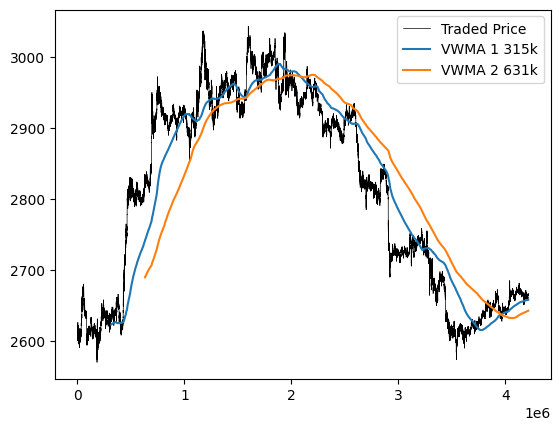

In [84]:
plt.plot(np.arange(ob_fq.shape[0]-1),ob_fq['Traded_Price'].iloc[1:], linewidth=0.5, color='black', label='Traded Price')
plt.plot(np.arange(periods1+1, ob_fq.shape[0]),vwma1, label='VWMA 1 ' + str(int(periods1/1000)) + 'k')
plt.plot(np.arange(periods2+2, ob_fq.shape[0]),vwma2, label='VWMA 2 ' + str(int(periods2/1000)) + 'k')
plt.legend()
plt.show()

In [91]:
trade_log = pd.DataFrame(trade_log, columns = ['Index', 'Timestamp', 'Side', 'VWAP', 'Vol'])
trade_log.to_csv('trade_log_'+exch+'.csv')
print(trade_log)

     Index               Timestamp  Side     VWAP       Vol
0   631997 2022-02-28 20:27:11.997   buy  2822.10  0.353992
1  2086039 2022-03-02 19:49:24.111  sell  2936.83  0.707275
2  3957195 2022-03-05 13:48:28.967   buy  2633.74  0.878552


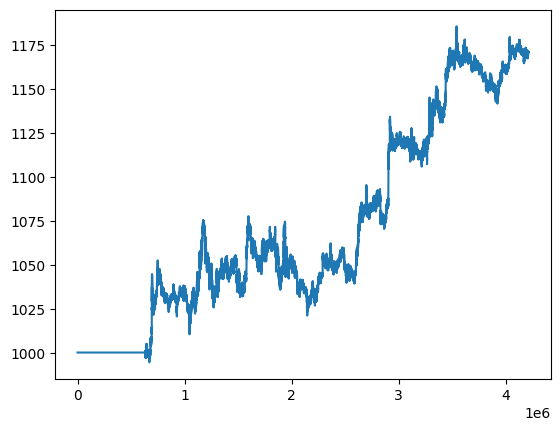

In [86]:
plt.plot(capital)
plt.show()

In [87]:
print('End Capital: ' + str(capital[-1]))
print('Overall Performance: ' + str(capital[-1]/initial_capital-1))

End Capital: 1170.7365803915666
Overall Performance: 0.17073658039156658


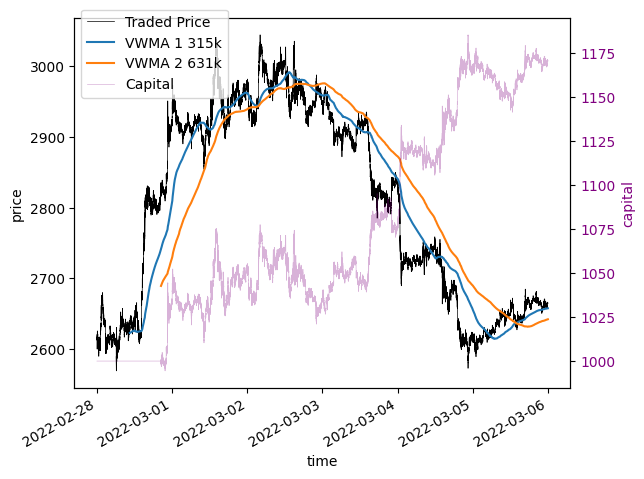

In [88]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time')
ax1.set_ylabel('price', color='black')
ax1.plot(ob_fq['datetime'].iloc[1:],ob_fq['Traded_Price'].iloc[1:], color='black',linewidth=0.5, label="Traded Price")
ax1.plot(ob_fq['datetime'].iloc[periods1+1:],vwma1, label='VWMA 1 ' + str(int(periods1/1000)) + 'k')
ax1.plot(ob_fq['datetime'].iloc[periods2+2:],vwma2, label='VWMA 2 ' + str(int(periods2/1000)) + 'k')
# ax1.plot(ob_fq['VWAP'].iloc[1:], color='red', label="VWAP")
ax1.tick_params(axis='y', labelcolor='black')
# ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'purple'
ax2.set_ylabel('capital', color=color)  # we already handled the x-label with ax1
ax2.plot(ob_fq['datetime'].iloc[1:],capital[1:],color=color,linewidth=0.5, label="Capital", alpha=0.3)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend()

fig.legend(['Traded Price', 'VWMA 1 ' + str(int(periods1/1000)) + 'k', 'VWMA 2 ' + str(int(periods2/1000)) + 'k', 'Capital'], loc=8, bbox_to_anchor=(0.25,0.7))

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

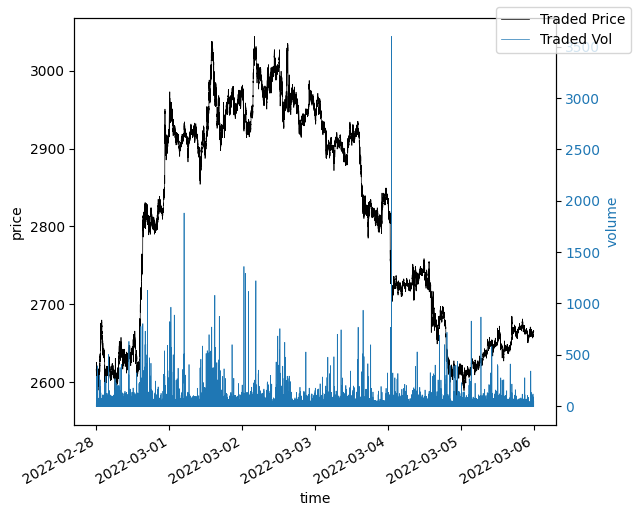

In [89]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time')
ax1.set_ylabel('price', color='black')
ax1.plot(ob_fq['datetime'].iloc[1:],ob_fq['Traded_Price'].iloc[1:], color='black',linewidth=0.5, label="Traded Price")
# ax1.plot(ob_fq['VWAP'].iloc[1:], color='red', label="VWAP")
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
ax2.plot(ob_fq['datetime'].iloc[1:],ob_fq['Traded_Volume_Abs'].iloc[1:], color=color,linewidth=0.5, label="Traded Vol")
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(['Traded Price', 'Traded Vol'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [90]:
# cumulated volume
print(t_vol[-1])

7233554.684804862
